# Wholesale Customer Segmentation: k-Means and Agglomerative Clustering

## A Comparative Analysis of Clustering Algorithms for Customer Segmentation

In this project, we'll apply unsupervised machine learning techniques to segment wholesale customers based on their purchasing behavior. We'll compare two popular clustering algorithms - k-Means and Agglomerative Clustering - to identify distinct customer segments that can inform business strategies.

### Dataset Information
The dataset contains annual spending data (in monetary units) on different product categories for 440 wholesale customers. Features include:
- Fresh: annual spending on fresh products
- Milk: annual spending on milk products
- Grocery: annual spending on grocery products
- Frozen: annual spending on frozen products
- Detergents_Paper: annual spending on detergents and paper products
- Delicassen: annual spending on delicatessen products
- Channel: customer channel (1: Horeca (Hotel/Restaurant/Cafe), 2: Retail)
- Region: customer region (1: Lisbon, 2: Oporto, 3: Other)

## 1. Import Libraries and Load Data

In [38]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

# Load the Wholesale Customers dataset
df = pd.read_csv('Wholesale_customers_data.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Features: {list(df.columns)}")

Dataset loaded successfully!
Dataset shape: (440, 8)
Features: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


## 2. Exploratory Data Analysis (EDA)

In [39]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None

First few rows:
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404

In [40]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000      

In [41]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


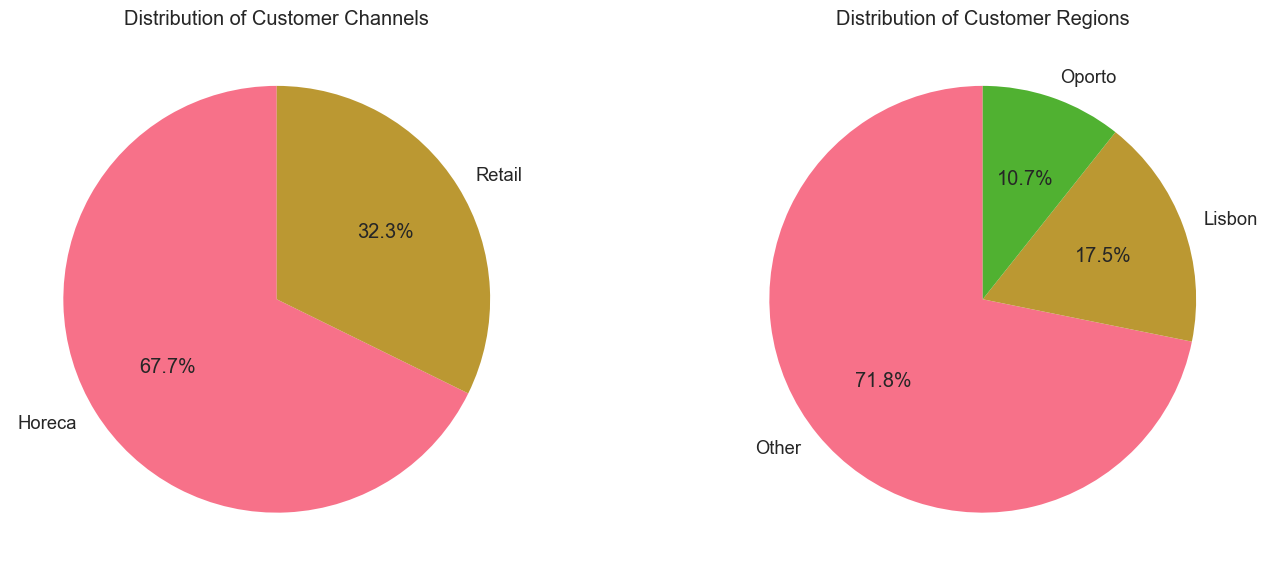

In [42]:
# Distribution of categorical variables
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Channel distribution
channel_counts = df['Channel'].value_counts()
axes[0].pie(channel_counts.values, labels=['Horeca', 'Retail'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution of Customer Channels')

# Region distribution
region_counts = df['Region'].value_counts()
axes[1].pie(region_counts.values, labels=['Other', 'Lisbon', 'Oporto'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribution of Customer Regions')

plt.tight_layout()
plt.show()

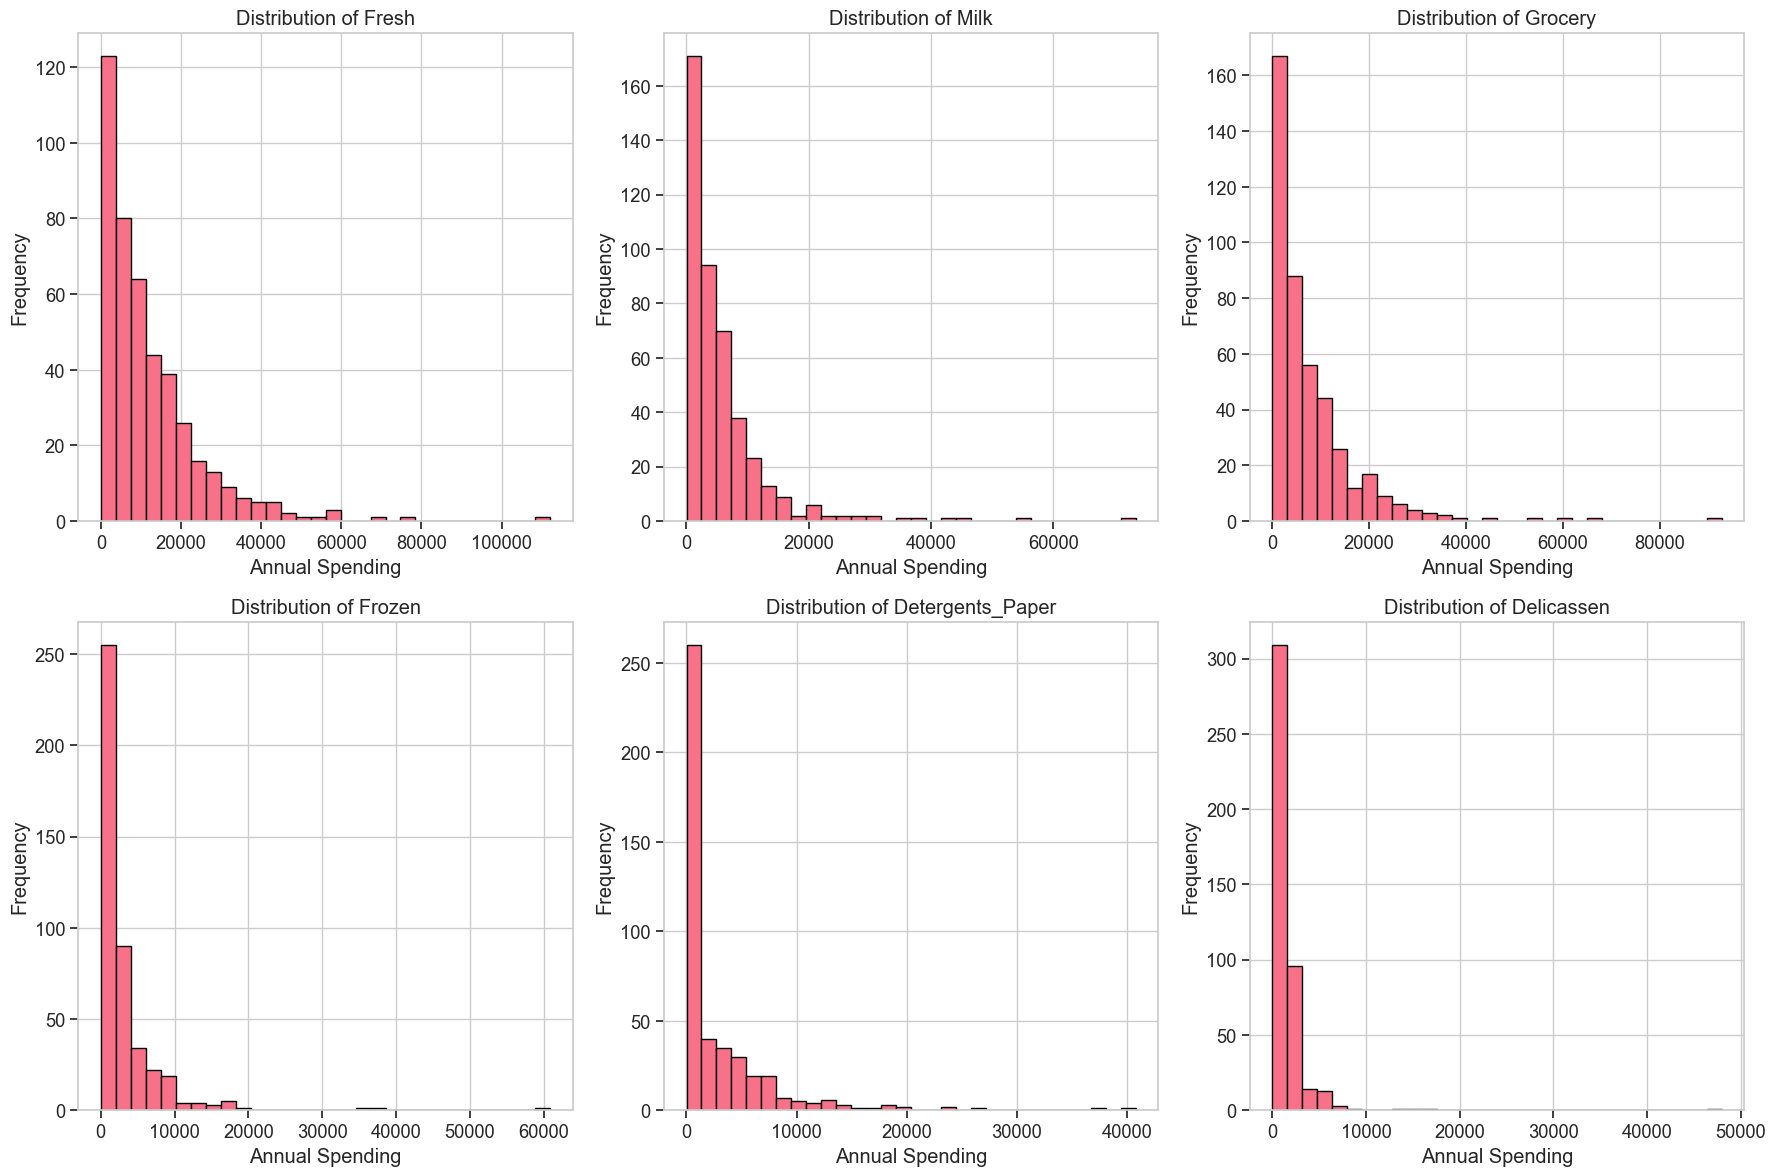

In [43]:
# Distribution of spending features
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(spending_features):
    axes[i].hist(df[feature], bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Annual Spending')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

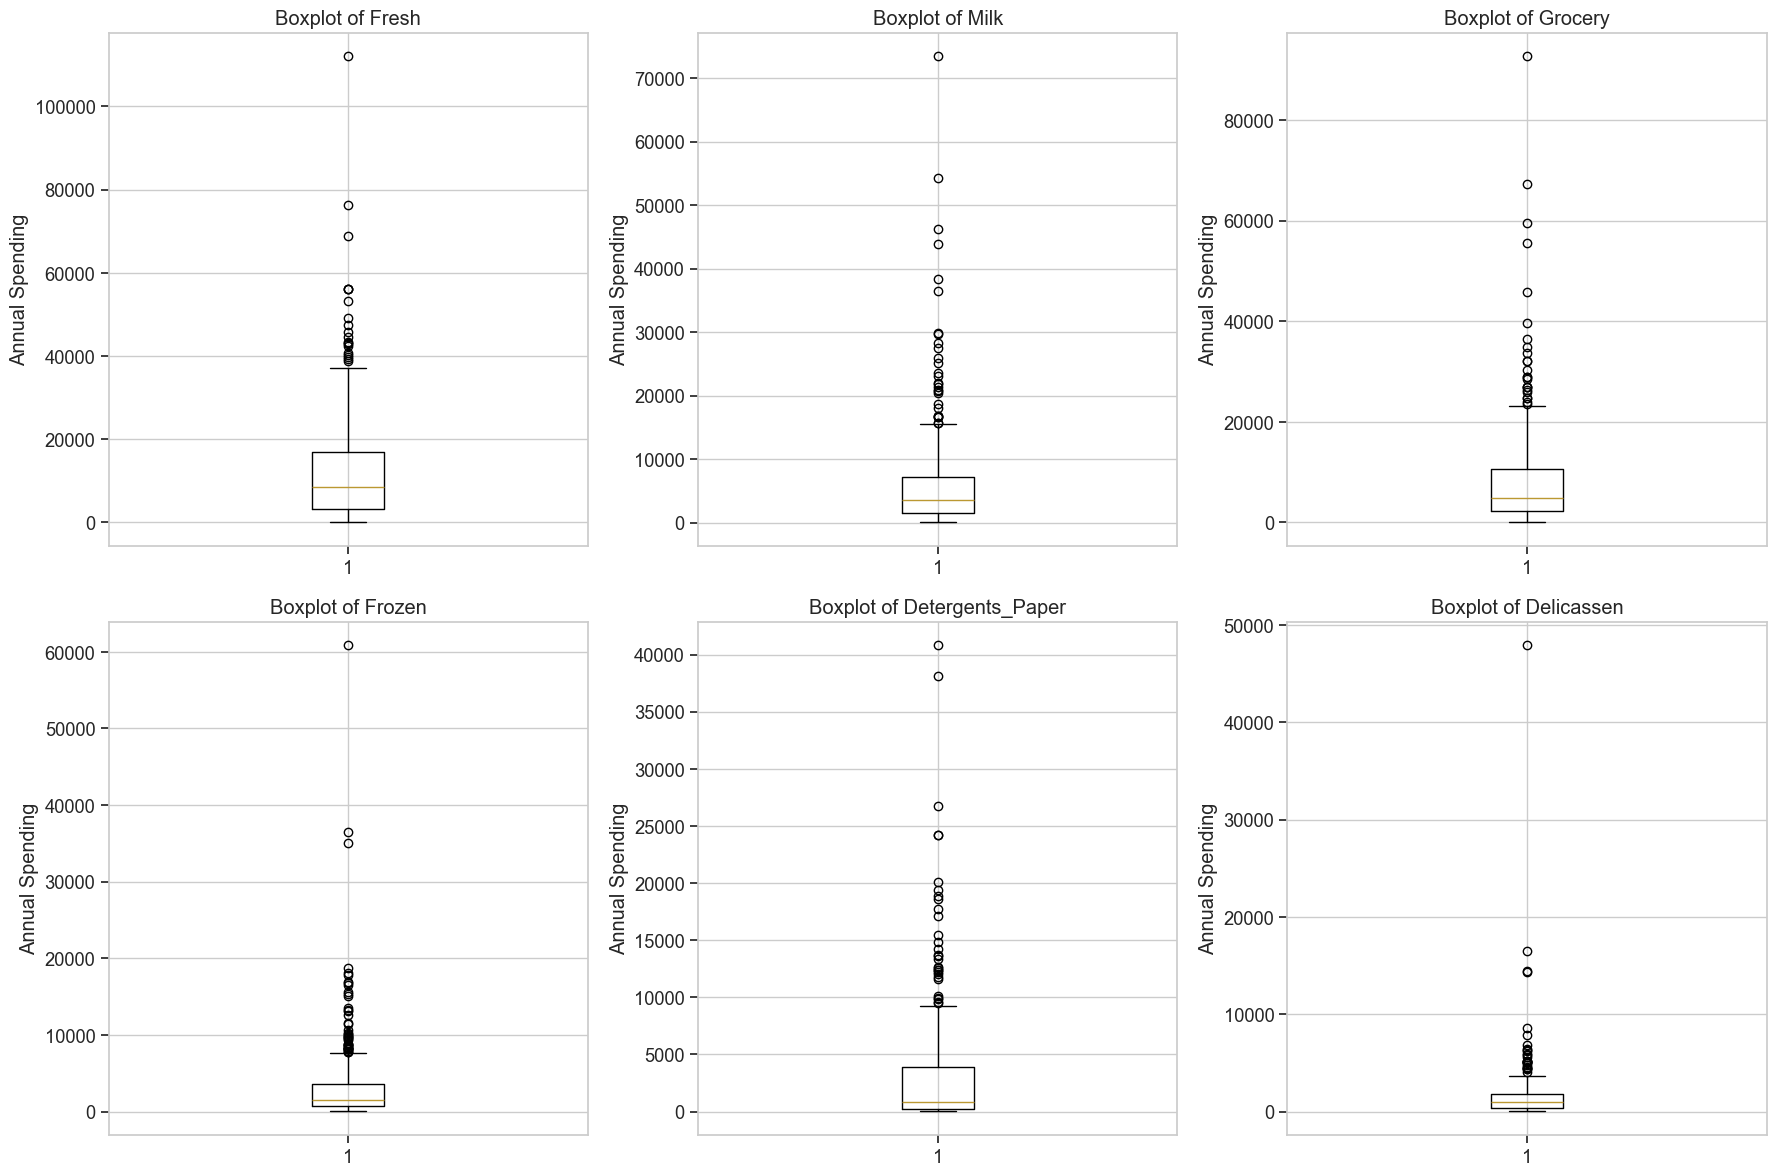

In [44]:
# Boxplots to detect outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(spending_features):
    axes[i].boxplot(df[feature])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_ylabel('Annual Spending')

plt.tight_layout()
plt.show()

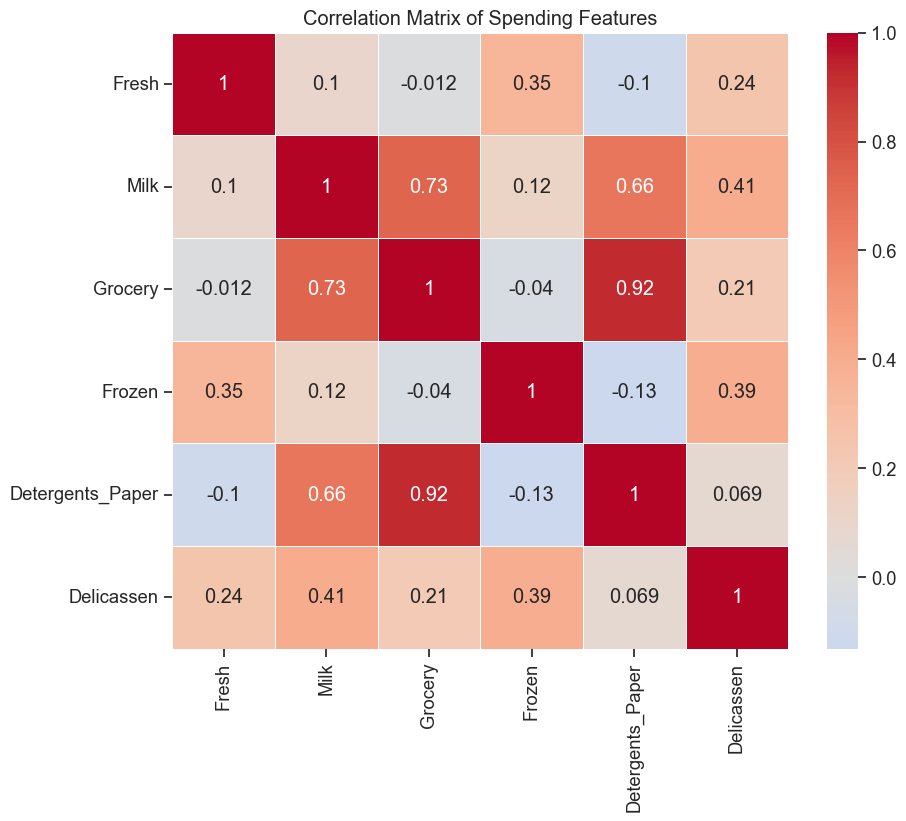

In [45]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[spending_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Spending Features')
plt.show()

## 3. Data Preprocessing

In [46]:
# For clustering, we'll use only the spending features
X = df[spending_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data preprocessing completed!")
print(f"Original data shape: {X.shape}")
print(f"Scaled data shape: {X_scaled.shape}")

Data preprocessing completed!
Original data shape: (440, 6)
Scaled data shape: (440, 6)


## 4. Determine Optimal Number of Clusters

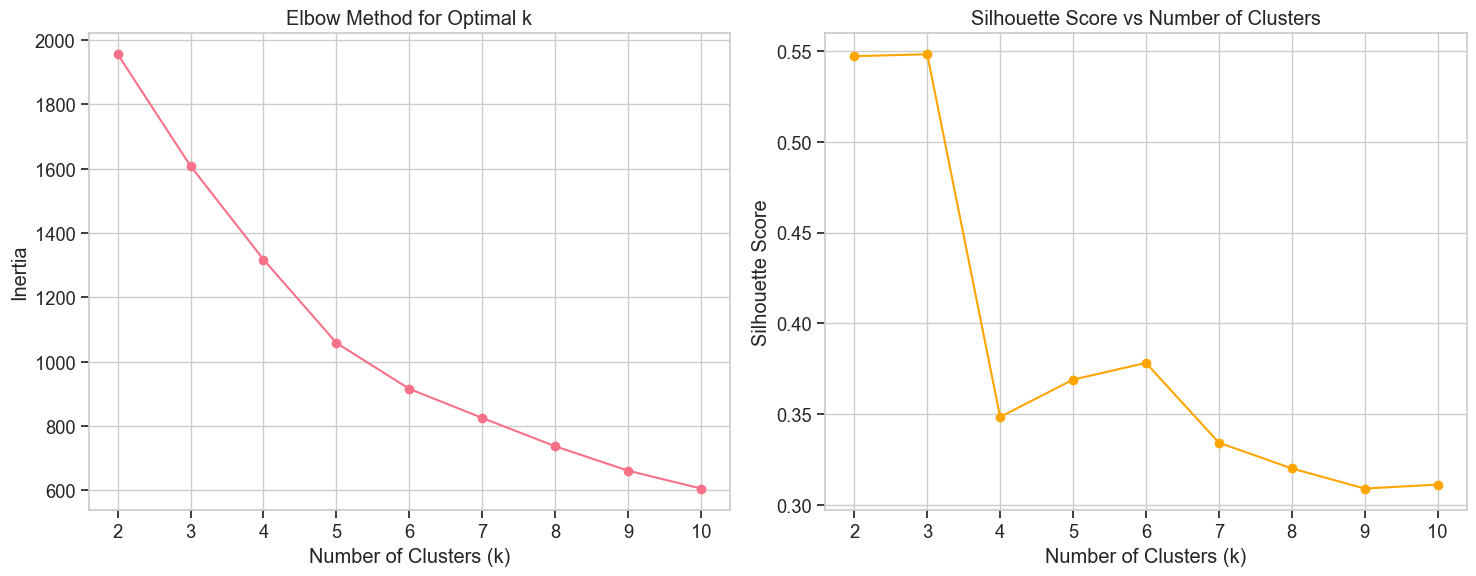

Best number of clusters based on silhouette score: 3
Best silhouette score: 0.5483


In [47]:
# Elbow method to find optimal number of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the elbow curve
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Elbow method plot
axes[0].plot(K_range, inertias, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True)

# Silhouette score plot
axes[1].plot(K_range, silhouette_scores, marker='o', color='orange')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Find the best k based on silhouette score
best_k = K_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters based on silhouette score: {best_k}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")

## 5. Implement k-Means Clustering

In [48]:
# Apply k-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df['KMeans_Cluster'] = kmeans_labels

print("k-Means clustering completed!")
print(f"Number of clusters: {best_k}")
print(f"Silhouette score: {silhouette_score(X_scaled, kmeans_labels):.4f}")
print("\nCluster distribution:")
print(df['KMeans_Cluster'].value_counts().sort_index())

k-Means clustering completed!
Number of clusters: 3
Silhouette score: 0.5483

Cluster distribution:
KMeans_Cluster
0     45
1    393
2      2
Name: count, dtype: int64


## 6. Visualize Clusters using PCA

In [49]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

Explained variance ratio: [0.44082893 0.283764  ]
Total variance explained: 0.7246


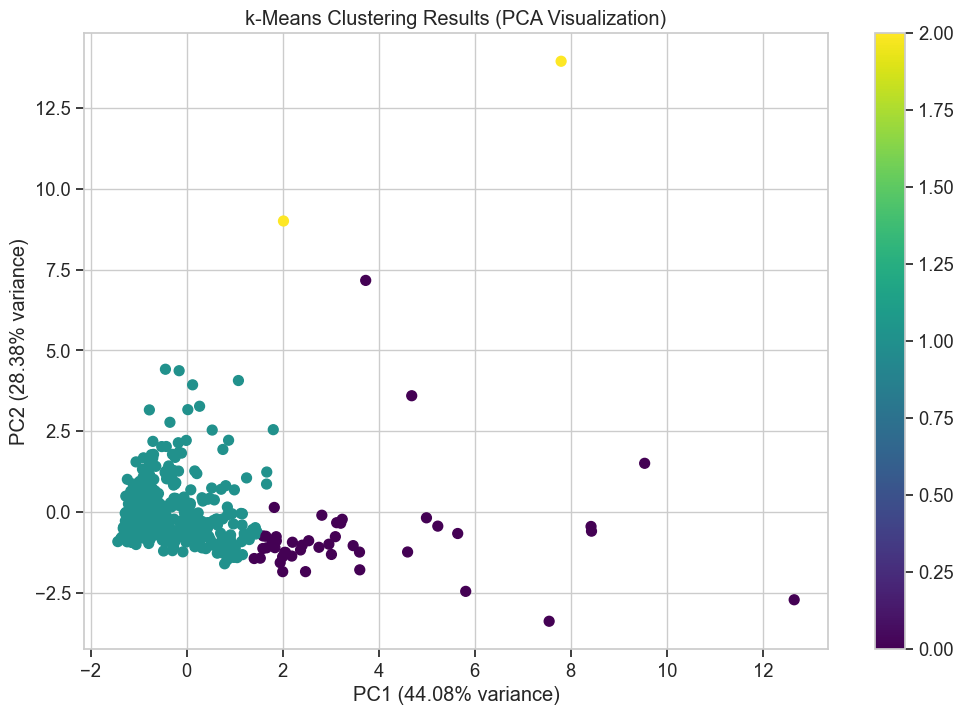

In [50]:
# Plot the clusters in 2D PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('k-Means Clustering Results (PCA Visualization)')
plt.colorbar(scatter)

# Save the plot
plt.savefig('kmeans_pca_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Implement Agglomerative Clustering (Comparison)

In [51]:
# Apply Agglomerative Clustering with the same number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=best_k)
agg_labels = agg_clustering.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df['Agg_Cluster'] = agg_labels

print("Agglomerative clustering completed!")
print(f"Number of clusters: {best_k}")
print(f"Silhouette score: {silhouette_score(X_scaled, agg_labels):.4f}")
print("\nCluster distribution:")
print(df['Agg_Cluster'].value_counts().sort_index())

Agglomerative clustering completed!
Number of clusters: 3
Silhouette score: 0.2646

Cluster distribution:
Agg_Cluster
0      6
1    281
2    153
Name: count, dtype: int64


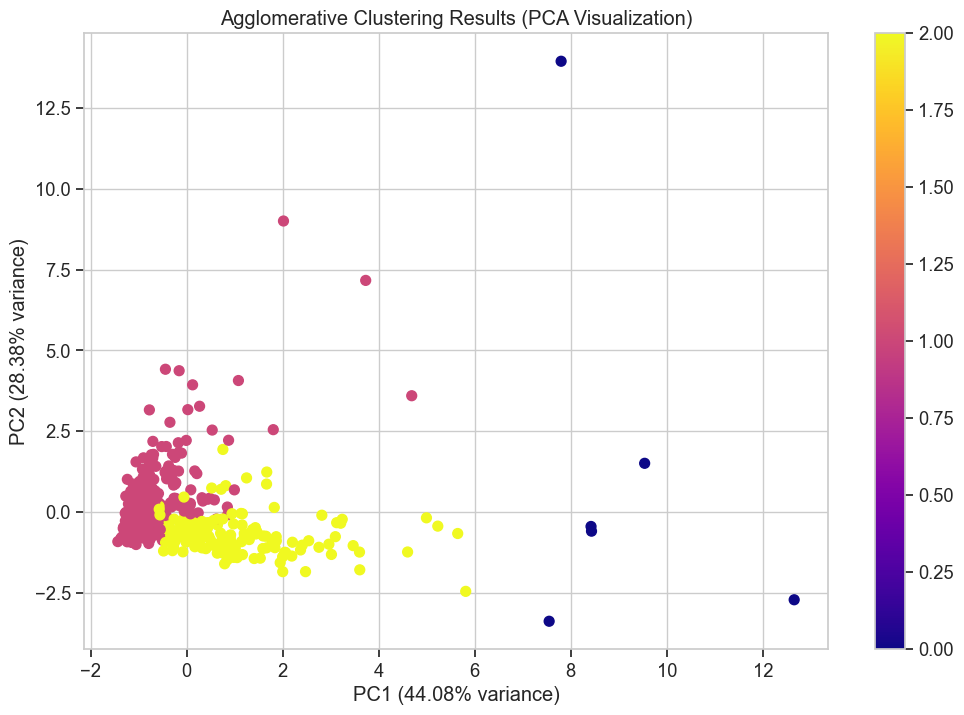

In [52]:
# Plot the Agglomerative clustering results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='plasma', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Agglomerative Clustering Results (PCA Visualization)')
plt.colorbar(scatter)

# Save the plot
plt.savefig('agglomerative_pca_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Cluster Profiling and Customer Personas

In [53]:
# Profile each cluster based on mean feature values
cluster_profiles = df.groupby('KMeans_Cluster')[spending_features].mean()
cluster_profiles = cluster_profiles.round(2)

print("Cluster Profiles (Mean Spending by Category):")
print(cluster_profiles)

# Add cluster sizes
cluster_sizes = df['KMeans_Cluster'].value_counts().sort_index()
cluster_profiles['Cluster_Size'] = cluster_sizes.values

# Save cluster profiles to CSV
cluster_profiles.to_csv('cluster_profiles.csv')
print("\nCluster profiles saved to 'cluster_profiles.csv'")

Cluster Profiles (Mean Spending by Category):
                   Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
KMeans_Cluster                                                             
0               10440.93  19386.42  28656.09   2190.24          13327.80   
1               12062.91   4115.10   5534.97   2940.68           1696.17   
2               34782.00  30367.00  16898.00  48701.50            755.50   

                Delicassen  
KMeans_Cluster              
0                  2374.20  
1                  1299.11  
2                 26776.00  

Cluster profiles saved to 'cluster_profiles.csv'


<Figure size 1200x800 with 0 Axes>

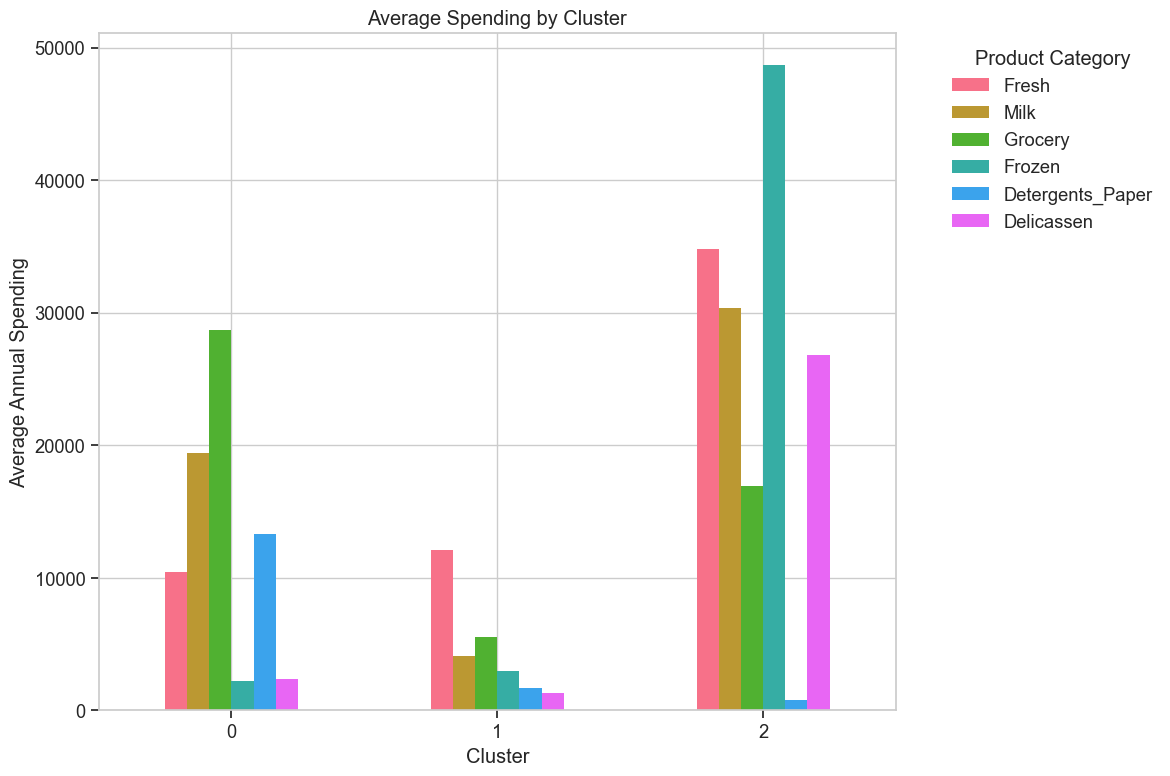

In [54]:
# Visualize cluster profiles
plt.figure(figsize=(12, 8))
cluster_profiles[spending_features].plot(kind='bar', figsize=(12, 8))
plt.title('Average Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Annual Spending')
plt.xticks(rotation=0)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 9. Customer Persona Interpretation

In [55]:
print("=" * 60)
print("CUSTOMER PERSONA INTERPRETATION")
print("=" * 60)

# Analyze each cluster based on spending patterns
for cluster_id in range(best_k):
    cluster_data = cluster_profiles.loc[cluster_id]
    print(f"\nCLUSTER {cluster_id} (Size: {int(cluster_data['Cluster_Size'])} customers):")
    
    # Identify the highest spending categories
    top_categories = cluster_data[spending_features].sort_values(ascending=False).head(3)
    print(f"  Top spending categories:")
    for i, (category, spending) in enumerate(top_categories.items(), 1):
        print(f"    {i}. {category}: {spending:,.0f}")
    
    # Determine cluster characteristics
    if cluster_data['Fresh'] > cluster_data[spending_features].median().median():
        print("  Characteristic: High spending on fresh products")
    elif cluster_data['Grocery'] > cluster_data[spending_features].median().median():
        print("  Characteristic: High spending on grocery products")
    elif cluster_data['Milk'] > cluster_data[spending_features].median().median():
        print("  Characteristic: High spending on milk products")
    else:
        print("  Characteristic: Balanced spending across categories")

CUSTOMER PERSONA INTERPRETATION

CLUSTER 0 (Size: 45 customers):
  Top spending categories:
    1. Grocery: 28,656
    2. Milk: 19,386
    3. Detergents_Paper: 13,328


AttributeError: 'numpy.float64' object has no attribute 'median'

## 10. Business Insights and Recommendations

In [ ]:
print("=" * 60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("=" * 60)

print("\nCLUSTER ANALYSIS:")
for cluster_id in range(best_k):
    cluster_size = int(cluster_profiles.loc[cluster_id, 'Cluster_Size'])
    cluster_pct = cluster_size / len(df) * 100
    print(f"\nCluster {cluster_id} ({cluster_size} customers, {cluster_pct:.1f}% of total):")
    
    # Determine if this is a high-value or low-value segment
    cluster_total_spending = cluster_profiles.loc[cluster_id, spending_features].sum()
    avg_spending = cluster_profiles[spending_features].sum(axis=1).mean()
    
    if cluster_total_spending > avg_spending * 1.2:
        value_segment = "HIGH-VALUE"
    elif cluster_total_spending < avg_spending * 0.8:
        value_segment = "LOW-VALUE"
    else:
        value_segment = "MEDIUM-VALUE"
    
    print(f"  Value Segment: {value_segment}")
    
    # Identify key product categories for this cluster
    top_category = cluster_profiles.loc[cluster_id, spending_features].idxmax()
    print(f"  Primary Focus: {top_category}")
    
    # Business recommendations
    if value_segment == "HIGH-VALUE":
        print("  Recommendation: Prioritize retention efforts and premium service")
    elif value_segment == "LOW-VALUE":
        print("  Recommendation: Explore opportunities for upselling or cross-selling")
    else:
        print("  Recommendation: Maintain current service levels and identify growth opportunities")

print("\nOVERALL RECOMMENDATIONS:")
print("1. Tailor marketing campaigns to specific cluster preferences")
print("2. Develop targeted product bundles based on cluster spending patterns")
print("3. Adjust inventory management to match cluster demand cycles")
print("4. Consider channel-specific strategies for Horeca vs Retail customers")
print("5. Monitor cluster evolution over time to adapt business strategies")

## 11. Model Comparison

In [ ]:
print("=" * 60)
print("MODEL COMPARISON: k-MEANS VS AGGLOMERATIVE CLUSTERING")
print("=" * 60)

# Compare silhouette scores
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
agg_silhouette = silhouette_score(X_scaled, agg_labels)

print(f"\nk-Means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Agglomerative Silhouette Score: {agg_silhouette:.4f}")

if kmeans_silhouette > agg_silhouette:
    print("\nConclusion: k-Means provides better clustering performance for this dataset.")
elif agg_silhouette > kmeans_silhouette:
    print("\nConclusion: Agglomerative clustering provides better clustering performance for this dataset.")
else:
    print("\nConclusion: Both algorithms perform equally well on this dataset.")

print("\nKey Differences:")
print("- k-Means is generally faster and more suitable for large datasets")
print("- Agglomerative clustering can capture more complex cluster shapes")
print("- k-Means assumes spherical clusters, while Agglomerative can handle various shapes")

## References

1. Abreu, N. (2011). Analysing supermarket customers' behaviour (Master's thesis). INESC TEC and Porto Business School.
2. scikit-learn documentation: https://scikit-learn.org/stable/
3. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.